In [1]:
import math
import struct

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import (Activation, Add,
                                            BatchNormalization, Convolution2D,
                                            Dense, Dropout, Flatten,
                                            GlobalAveragePooling2D, Input,
                                            Lambda, Multiply, concatenate)
from tensorflow.python.keras.layers.pooling import MaxPooling2D
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.optimizers import SGD, Adam, Adamax, nadam
from tensorflow.python.keras.utils import Sequence, to_categorical

from PIL import Image, ImageEnhance

In [8]:
class ETL9B:
    def __init__(self, path, num, label_num, drop_records=[], seek=0):
        self.labels = label_num
        self.max_nums = num
        self.image_shape = [63, 64]
        self.filename = path
        self.drop_records = drop_records
        self.file = open(self.filename, 'rb')
        self.seek = seek
        
    def is_dropped(self, label, num):
        if self.drop_records:
            for drop_record in self.drop_records:
                if drop_record[0] == label and drop_record[1] == num:
                    return True
        return False
    
    def _read(self, skip):
        record_size = 576
        self.file.seek(skip * record_size)
        s = self.file.read(record_size)
        r = struct.unpack('>2H4s504s64x', s)
        i1 = Image.frombytes('1', (64, 63), r[3], 'raw')
        return np.array(i1)
        
    def get_chars(self):
        images = []
        labels = []
        seek = self.seek
        for num in range(self.max_nums):
            for label in range(self.labels):
                if not self.is_dropped(label, num):
                    x = self._read(label + seek + self.labels*num)
                    images.append(x)
                    labels.append(label)
                else:
                    seek -= 1
        return np.asarray(images, dtype=np.float32)[..., np.newaxis], to_categorical(np.asarray(labels), self.labels)

In [9]:
etl9b_path = '/Users/chai/etlcdb/ETL9B/'
etl9b_x = []
etl9b_y = []
for i in range(5):
    x, y = ETL9B(etl9b_path + 'ETL9B_' + str(i+1), 40, 3036, seek=1).get_chars()
    etl9b_x.extend(x)
    etl9b_y.extend(y)
etl9b = [np.asarray(etl9b_x), np.asarray(etl9b_y)]

In [10]:
etl9b[0].dtype

dtype('float32')

In [22]:
batch_size = 30
num_class = 3036
split_num = 500000
train_data = [etl9b[0][:split_num], etl9b[1][:split_num]]
test_data = [etl9b[0][split_num:], etl9b[1][split_num:]]
# train_data_seq = ETL_sequence(train_data, batch_size, num_class)
# test_data_seq = ETL_sequence(test_data, batch_size, num_class)

In [23]:
def se_block(in_block, ch, ratio=16):
    z = GlobalAveragePooling2D()(in_block)
    x = Dense(ch//ratio, activation='relu')(z)
    x = Dense(ch, activation='sigmoid')(x)
    return Multiply()([in_block, x])

In [24]:
def vgg(x, num_class):
    residual = Convolution2D(32, [1, 1])(x)
    x = Convolution2D(32, (5, 5), padding='same', activation='relu')(x)
    x = Convolution2D(32, (5, 5), padding='same', activation='relu')(x)
    x = se_block(x, 32)
    x = Add()([x, residual])
    x = MaxPooling2D(pool_size=(2, 2))(x)
    residual = Convolution2D(64, [1, 1])(x)
    x = Dropout(0.25)(x)
    
    x = Convolution2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Convolution2D(64, (3, 3), padding='same', activation='relu')(x)
    x = se_block(x, 64)
    x = Add()([x, residual])
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    # x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(num_class, activation='softmax')(x)
    return x

In [25]:
img_input = Input(shape=(63, 64, 1))
model = Model(img_input, vgg(img_input, num_class))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 63, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 63, 64, 32)   832         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 63, 64, 32)   25632       conv2d_7[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_2 (Glo (None, 32)           0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
dense_6 (D

In [26]:
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# fit_generator = model.fit_generator(train_data_seq, epochs=1, validation_data=test_data_seq, initial_epoch=0)

In [28]:
epochs = 1
fit = model.fit(x=train_data[0], y=train_data[1], batch_size=batch_size, epochs=1, validation_data=test_data)

Train on 500000 samples, validate on 107200 samples
Epoch 1/1
   660/500000 [..............................] - ETA: 49:19:50 - loss: 8.4690 - acc: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
def plot_loss_acc(fit):
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(fit.history['loss'], label="loss for training")
    ax[0].plot(fit.history['val_loss'], label="loss for validation")
    ax[0].set_title('model loss')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    plt.legend(loc='upper right')
    
    ax[1].plot(fit.history['metrics'])
    ax[1].plot(fit.history['val_metrics'])
    ax[1].set_title('model accuracy')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    plt.show()

In [ ]:
plot_loss_acc(fit_generator)

In [ ]:
model.save('keras_to_tensorflow/keras_model/keras_model')

In [ ]:
np.argmax(model.predict(test_data[0][3].reshape([1, 63, 64, 1])))

2097
1


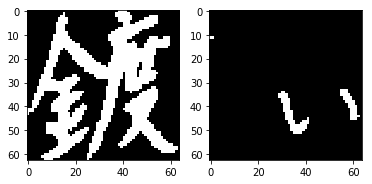

In [11]:
num = 1
cop = [test_data[0][num], train_data[0][num]]
cop = np.squeeze(cop)
print(test_data[1][num])
print(train_data[1][num])
for i in range(2):
    im = cop[i]
    
    num = 330 + i + 1
    plt.subplot(1, 2, i + 1)
    plt.gray()
    plt.imshow(im)
plt.show()